In [38]:
import pandas as pd
import numpy as np
import torch
from scipy import stats
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.utils import negative_sampling
from torch_geometric_temporal import recurrent
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal, DynamicHeteroGraphTemporalSignal
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import HeteroGCLSTM
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.nn import GATConv, HeteroConv

import sys
sys.path.append('../utils')
from probabilistic_util_fuctions import generate_rfm_data2, generate_rfm_data
import importlib
import TGN_util_functions
importlib.reload(TGN_util_functions)
from TGN_util_functions import *
import discreteTGNN_models
importlib.reload(discreteTGNN_models)
from discreteTGNN_models import *


#df = pd.read_excel('Online Retail.xlsx')
df = pd.read_csv('online_retail_II.csv')

df.rename(columns = {'Customer ID':'CustomerID', 
                     'Price': 'UnitPrice', 
                     'Invoice': "InvoiceNo"}, inplace = True)


df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [15]:
df_processed, country_embedding, description_embedding = data_preprocessing(df)
orders_df, customer_df = get_orders_df(df_processed)
df_processed.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Month,day_of_week,hour_minute,day_sin,day_cos,time_of_day,TotalPrice,Amount,FirstOrder,CountryID,DescriptionID
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,2009-12,1,07:45:00,0.781831,0.62349,morning,83.4,83.4,2009-12-01 07:45:00,38,60
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12,1,07:45:00,0.781831,0.62349,morning,81.0,81.0,2009-12-01 07:45:00,38,3270
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12,1,07:45:00,0.781831,0.62349,morning,81.0,81.0,2009-12-01 07:45:00,38,35
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,2009-12,1,07:45:00,0.781831,0.62349,morning,100.8,100.8,2009-12-01 07:45:00,38,3598
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,2009-12,1,07:45:00,0.781831,0.62349,morning,30.0,30.0,2009-12-01 07:45:00,38,4591


In [16]:
edge_index_list, edge_weights_list, feature_list, target_list = create_dynamic_graph(df_processed, start_t=3, end_t=-3)

dataset = DynamicHeteroGraphTemporalSignal(
    edge_index_dicts=edge_index_list,
    edge_weight_dicts=edge_weights_list,
    feature_dicts=feature_list,
    target_dicts=target_list
)

In [17]:
dataset[-1]

HeteroData(
  customer={
    x=[5790, 15],
    y=[5790],
  },
  product={ x=[4610, 5] },
  active_customer_ids={ y=[5192] },
  (customer, purchases, product)={
    edge_index=[2, 626906],
    edge_attr=[385738, 4],
  },
  (customer, self, customer)={
    edge_index=[2, 5192],
    edge_attr=[5192],
  }
)

In [ ]:
#Prepare the dataset for training and testing

#I make sure to avoid data leakage by using the last 3 snapshots for testing
train_dataset = dataset[:-3]
test_dataset = dataset[-1]

#scaling the features
scaler_customer = compute_normalization_param(train_dataset, node_type='customer')
scaler_product = compute_normalization_param(train_dataset, node_type='product')
scaler_edge = compute_normalization_param_edge(train_dataset)

scaled_train_dataset = normalize_dataset(train_dataset, scaler_customer, scaler_product, scaler_edge)
scaled_test_dataset = normalize_snapshot(test_dataset, scaler_customer, scaler_product, scaler_edge)

In [20]:
scaled_train_dataset[0][('customer', 'purchases', 'product')].edge_attr

tensor([[ 0.8440, -0.0777,  0.9322,  0.7755],
        [ 0.8007,  0.3617, -0.9924, -1.2581],
        [ 0.8007,  0.3617, -0.9924, -1.2581],
        ...,
        [ 2.0976, -0.3524,  1.2379, -0.3530],
        [-0.3016, -0.0777,  1.2379, -0.3530],
        [-0.3448,  0.2518,  1.2379, -0.3530]])

In [25]:
#SUPERVISED LEARNING MODELS
#model = CLVModelAdjusted(country_embedding, description_embedding, dataset[0].metadata(), num_layers=2) #not very good model 
#model = CLVModelAttention2(country_embedding, description_embedding, dataset[0].metadata(), hidden_dim=64, num_layers=2, heads = 2)
#model_supervised = CLVModelAttention(country_embedding, description_embedding, dataset[0].metadata(), hidden_dim=128, num_layers=1, heads = 1) #Good model cofiguration
#model_supervised = CLVModel(country_embedding, description_embedding, dataset[0].metadata())
#trained_model_supervised, last_h_dict, last_c_dict = train2(model_supervised, scaled_train_dataset, epochs=50, patience=10)

#SELF-SUPERVISED LEARNING MODELS
model_self_supervised = TGNSelfSupervised(country_embedding, description_embedding, scaled_train_dataset[0].metadata(), hidden_dim=128, num_layers=1, heads = 1)
trained_model, last_h_dict, last_c_dict = train_self_supervised(model_self_supervised, scaled_train_dataset, epochs=50, patience=7)

#model = TGNSelfSupervisedLP(country_embedding, description_embedding, scaled_train_dataset[0].metadata(), hidden_dim=64, num_layers=1, heads = 4)
#trained_model, last_h_dict, last_c_dict = train_link_prediction(model, scaled_train_dataset, epochs=50, patience=10)

/Users/ip/Desktop/JOB/DataScience-projects/CLV prediction with temporal graph neural networks/notebooks/../utils/discreteTGNN_models.py:787: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_edge_index = torch.tensor(


Epoch 1/50, Loss: 4.1363
Epoch 2/50, Loss: 2.4369
Epoch 3/50, Loss: 1.8903
Epoch 4/50, Loss: 1.4596
Epoch 5/50, Loss: 1.3107
Epoch 6/50, Loss: 1.0406
Epoch 7/50, Loss: 0.9913
Epoch 8/50, Loss: 0.9251
Epoch 9/50, Loss: 0.8174
Epoch 10/50, Loss: 0.8105
Epoch 11/50, Loss: 0.7527
Epoch 12/50, Loss: 0.7081
Epoch 13/50, Loss: 0.6286
Epoch 14/50, Loss: 0.5881
Epoch 15/50, Loss: 0.5381
Epoch 16/50, Loss: 0.4967
Epoch 17/50, Loss: 0.4601
Epoch 18/50, Loss: 0.4190
Epoch 19/50, Loss: 0.4052
Epoch 20/50, Loss: 0.4081
Epoch 21/50, Loss: 0.3981
Epoch 22/50, Loss: 0.3797
Epoch 23/50, Loss: 0.3717
Epoch 24/50, Loss: 0.3609
Epoch 25/50, Loss: 0.3460
Epoch 26/50, Loss: 0.3434
Epoch 27/50, Loss: 0.3395
Epoch 28/50, Loss: 0.3474
Epoch 29/50, Loss: 0.3582
Epoch 30/50, Loss: 0.3446
Epoch 31/50, Loss: 0.3235
Epoch 32/50, Loss: 0.3177
Epoch 33/50, Loss: 0.3228
Epoch 34/50, Loss: 0.3161
Epoch 35/50, Loss: 0.3126
Epoch 36/50, Loss: 0.3139
Epoch 37/50, Loss: 0.3159
Epoch 38/50, Loss: 0.3139
Epoch 39/50, Loss: 0.

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error
def smape(y_true, y_pred, epsilon = 1e-5):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  #y_true = np.maximum(y_true, 10)  # Ensure no negative values in y_true
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  denominator = np.where(denominator == 0, epsilon, denominator)  # Avoid division by zero
  diff = np.abs(y_true - y_pred)
  smape_value = np.mean(diff / denominator)*100
  return smape_value

def adjusted_mape(y_true, y_pred): 
    y_true = np.maximum(y_true, 100)  # Ensure no negative values in y_true
    y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def test_model(model, test_dataset, h_dict = None, c_dict = None):

    model.eval()
    with torch.no_grad():
        predictions,_,_ = model(test_dataset.x_dict, test_dataset.edge_index_dict, h_dict, c_dict)
        active_customer_ids = test_dataset['active_customer_ids']['y']
        predictions_active = predictions[active_customer_ids]
        # ensure non-negativity predictions 
        predictions_active = torch.clamp(predictions_active, min=0.0)
        
        targets = test_dataset['customer'].y[active_customer_ids]
        #targets =  test_dataset['customer'].y
        if targets.ndim == 1:
            targets = targets.unsqueeze(1)
        
        mse = F.mse_loss(predictions_active, targets)
        mae = mean_absolute_error(targets.cpu().numpy(), predictions_active.cpu().numpy())
        rmse = torch.sqrt(mse)
        smpe = smape(targets.cpu().numpy(), predictions_active.cpu().numpy())
        adj_mape = adjusted_mape(targets.cpu().numpy(), predictions_active.cpu().numpy())
        r2 = r2_score(targets, predictions_active)
        metrics_df = pd.DataFrame({
            'RMSE': [rmse.item()],
            'MAE': [mae],
            'SMAPE': [smpe],
            'Adjusted MAPE': [adj_mape],
            'R2': [r2]

        })
        results_df = pd.DataFrame({
            'Predictions': predictions_active.cpu().numpy().flatten(),
            'Targets': targets.cpu().numpy().flatten()
        })

    

    return  metrics_df, results_df

In [ ]:
#Supervised learning model evaluation

metrics_df, results_supervised_training = test_model(trained_model_supervised, scaled_test_dataset, last_h_dict, last_c_dict)
metrics_df

,RMSE,MAE,SMAPE,Adjusted MAPE,R2
0,717.170105,222.913422,152.98568,96.770477,0.633059


/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_38932/2136019138.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


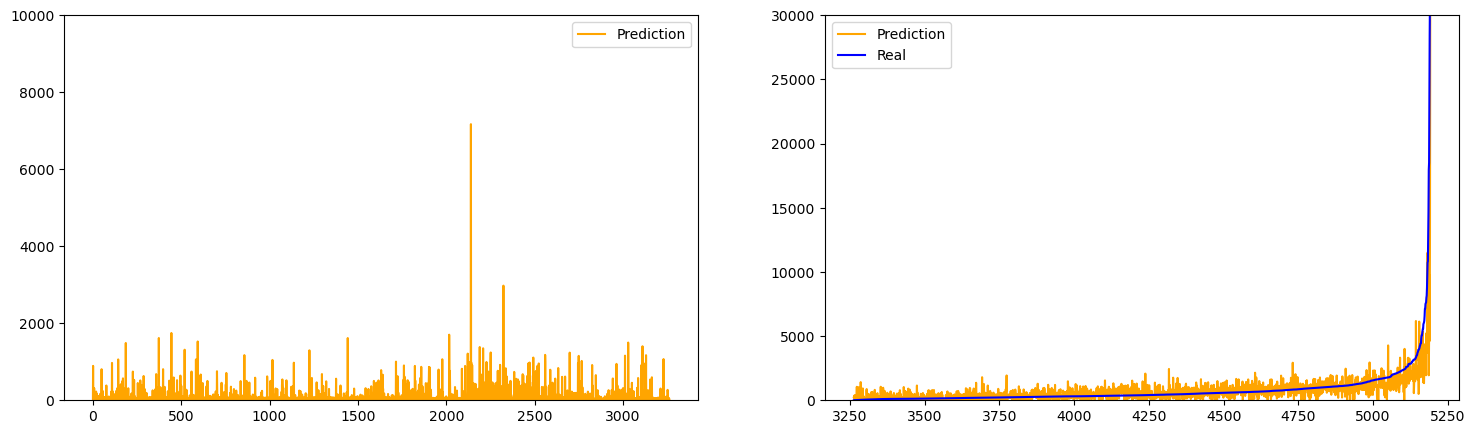

In [35]:
#put the predictions and targets in a dataframe
test_df = results_supervised_training.copy()
#order the dataframe by the targets
test_df = test_df.sort_values(by='Targets', ascending=True).reset_index(drop=True)
positive_df = test_df[test_df['Targets'] -1> 0]
zero_df = test_df[test_df['Targets'] == 0]

#plot the predictions and targets in the same plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (18, 5))
ax[1].plot(positive_df['Predictions'], color = 'orange', label = 'Prediction')
ax[1].plot(positive_df['Targets'],color  = 'blue', label  = 'Real')
#ax[1].set_ylim(0, 5e5)
ax[1].legend()
ax[0].plot( zero_df['Predictions'], color = 'orange', label = 'Prediction')
#ax[0].plot( zero_df['targets'], color  = 'blue', label  = 'Real')
ax[0].legend()
ax[1].set_ylim(0, 30000)
ax[0].set_ylim(0, 10000)
fig.show()




In [26]:
# Self-supervised learning model evaluation
X_train = last_h_dict['customer'].cpu().numpy()
y_train = scaled_train_dataset[-1]['customer'].y.numpy()

active_customer_ids = test_dataset['active_customer_ids']['y']

h_test, c_test = trained_model(scaled_test_dataset.x_dict, scaled_test_dataset.edge_index_dict, last_h_dict, last_c_dict)
h_test = {k: v.detach() for k, v in h_test.items()}
X_test = h_test['customer'].cpu().numpy()
X_test = X_test[active_customer_ids]
y_test = scaled_test_dataset['customer'].y[active_customer_ids]



In [27]:
# Use the embeddings for regression with LightGBM
# Perform hyperparameter optimization using Optuna with TimeSeries Cross-Validation


import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit # For chronological cross-validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # Assuming X_clv_full_train and y_clv_full_train are available


def objective_cv(trial, X_data, y_data): # Pass X and y as arguments
    """
    Objective function for Optuna with TimeSeries Cross-Validation.
    """
    
    lgbm_params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 91, # Seed for LightGBM's randomness
        'n_estimators': trial.suggest_int('n_estimators', 300, 2500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    # --- Cross-Validation Setup ---
    # For CLV, if your samples (embeddings generated weekly) are in chronological order,
    # TimeSeriesSplit is appropriate.
    n_splits = 5 # Or 3, depending on your dataset size and computational budget
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    fold_rmses = []

    # Convert to NumPy if X_data/y_data are Pandas DataFrames/Series for tscv compatibility if needed
    # Though tscv.split usually works with pandas indices too. For safety with lgb.fit:
    if isinstance(X_data, pd.DataFrame): X_data_np = X_data.values
    else: X_data_np = X_data
    if isinstance(y_data, pd.Series): y_data_np = y_data.values
    else: y_data_np = y_data

    print(f"  Trial {trial.number}: Starting {n_splits}-fold TimeSeriesSplit with params: {trial.params}")
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_data_np)):
        # print(f"    Fold {fold+1}/{n_splits}")
        X_train_fold, X_val_fold = X_data_np[train_idx], X_data_np[val_idx]
        y_train_fold, y_val_fold = y_data_np[train_idx], y_data_np[val_idx]

        model = lgb.LGBMRegressor(**lgbm_params)
        
        model.fit(
            X_train_fold, 
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # Early stopping per fold
        )
        
        preds = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        fold_rmses.append(rmse)
        # print(f"      Fold {fold+1} RMSE: {rmse:.4f}")

    average_rmse = np.mean(fold_rmses)
    print(f"  Trial {trial.number}: Average RMSE across {n_splits} folds: {average_rmse:.4f}")
    
    return average_rmse

# --- Optuna Study Setup ---
study_name_cv = "lgbm_clv_optimization_cv"
study_cv = optuna.create_study(
    study_name=study_name_cv,
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2, n_min_trials=3) # Prune after 2 trials if not promising, ensure at least 3 trials run this far.
)

print(f"\nStarting Optuna study with Cross-Validation: {study_name_cv}")
# Use a lambda function to pass X_clv_full_train and y_clv_full_train to the objective
study_cv.optimize(lambda trial: objective_cv(trial, X_train, y_train), 
                  n_trials=50, # Adjust number of trials as needed
                  timeout=1800) # Example: 30 minutes timeout

# --- Get and Print Best Results ---
print("\nCV Study statistics: ")
print("  Number of finished trials: ", len(study_cv.trials))

best_trial_cv = study_cv.best_trial

print("\nBest trial from CV study:")
print(f"  Value (Average RMSE): {best_trial_cv.value:.4f}")
print("  Best hyperparameters: ")
for key, value in best_trial_cv.params.items():
    print(f"    {key}: {value}")

# --- Step 5: Train Final Model with Best Hyperparameters on Full Training Data ---
print("\nTraining final LightGBM model using best hyperparameters from CV study on full training data...")
best_params_cv = best_trial_cv.params


final_lgbm_model = lgb.LGBMRegressor(objective='regression_l2', metric='rmse', verbosity=-1, boosting_type='gbdt', random_state=42, **best_params_cv)
final_lgbm_model.fit(X_train, y_train) 
print("Final LightGBM model trained.")

[I 2025-07-23 11:56:40,143] A new study created in memory with name: lgbm_clv_optimization_cv



Starting Optuna study with Cross-Validation: lgbm_clv_optimization_cv
  Trial 0: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2400, 'learning_rate': 0.002130782851682635, 'num_leaves': 256, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.6433652174230724, 'colsample_bytree': 0.925539320226912, 'reg_alpha': 2.1840480742829918e-05, 'reg_lambda': 0.041237071576998206}


[I 2025-07-23 11:57:00,028] Trial 0 finished with value: 427.19458079127645 and parameters: {'n_estimators': 2400, 'learning_rate': 0.002130782851682635, 'num_leaves': 256, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.6433652174230724, 'colsample_bytree': 0.925539320226912, 'reg_alpha': 2.1840480742829918e-05, 'reg_lambda': 0.041237071576998206}. Best is trial 0 with value: 427.19458079127645.


  Trial 0: Average RMSE across 5 folds: 427.1946
  Trial 1: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1150, 'learning_rate': 0.001034883133200481, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 80, 'subsample': 0.7334164537197712, 'colsample_bytree': 0.7608914887859439, 'reg_alpha': 0.0005288918579660528, 'reg_lambda': 0.0019287208119988836}


[I 2025-07-23 11:57:09,766] Trial 1 finished with value: 483.4509145204097 and parameters: {'n_estimators': 1150, 'learning_rate': 0.001034883133200481, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 80, 'subsample': 0.7334164537197712, 'colsample_bytree': 0.7608914887859439, 'reg_alpha': 0.0005288918579660528, 'reg_lambda': 0.0019287208119988836}. Best is trial 0 with value: 427.19458079127645.


  Trial 1: Average RMSE across 5 folds: 483.4509
  Trial 2: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1400, 'learning_rate': 0.14065536161342762, 'num_leaves': 209, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.5368051723521825, 'colsample_bytree': 0.6213362480426121, 'reg_alpha': 0.22448717683632022, 'reg_lambda': 3.227654345656791e-08}


[I 2025-07-23 11:57:14,792] Trial 2 finished with value: 417.87820347694577 and parameters: {'n_estimators': 1400, 'learning_rate': 0.14065536161342762, 'num_leaves': 209, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.5368051723521825, 'colsample_bytree': 0.6213362480426121, 'reg_alpha': 0.22448717683632022, 'reg_lambda': 3.227654345656791e-08}. Best is trial 2 with value: 417.87820347694577.


  Trial 2: Average RMSE across 5 folds: 417.8782
  Trial 3: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1000, 'learning_rate': 0.004021938278032378, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8489071932596617, 'colsample_bytree': 0.8440450346837511, 'reg_alpha': 1.6810418437614696e-07, 'reg_lambda': 0.13934115608065037}


[I 2025-07-23 11:57:23,024] Trial 3 finished with value: 421.95866492843595 and parameters: {'n_estimators': 1000, 'learning_rate': 0.004021938278032378, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8489071932596617, 'colsample_bytree': 0.8440450346837511, 'reg_alpha': 1.6810418437614696e-07, 'reg_lambda': 0.13934115608065037}. Best is trial 2 with value: 417.87820347694577.


  Trial 3: Average RMSE across 5 folds: 421.9587
  Trial 4: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1300, 'learning_rate': 0.011535726302791467, 'num_leaves': 202, 'max_depth': 15, 'min_child_samples': 81, 'subsample': 0.9552505303199735, 'colsample_bytree': 0.842942405190548, 'reg_alpha': 6.004592663149145e-07, 'reg_lambda': 1.8561915043785976e-08}


[I 2025-07-23 11:57:32,065] Trial 4 finished with value: 426.2042468937713 and parameters: {'n_estimators': 1300, 'learning_rate': 0.011535726302791467, 'num_leaves': 202, 'max_depth': 15, 'min_child_samples': 81, 'subsample': 0.9552505303199735, 'colsample_bytree': 0.842942405190548, 'reg_alpha': 6.004592663149145e-07, 'reg_lambda': 1.8561915043785976e-08}. Best is trial 2 with value: 417.87820347694577.


  Trial 4: Average RMSE across 5 folds: 426.2042
  Trial 5: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2400, 'learning_rate': 0.005250462871178904, 'num_leaves': 88, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.8480038144563292, 'colsample_bytree': 0.6605785311501635, 'reg_alpha': 0.00021560960092067218, 'reg_lambda': 1.8572144216347466e-05}


[I 2025-07-23 11:58:34,616] Trial 5 finished with value: 382.2354646395198 and parameters: {'n_estimators': 2400, 'learning_rate': 0.005250462871178904, 'num_leaves': 88, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.8480038144563292, 'colsample_bytree': 0.6605785311501635, 'reg_alpha': 0.00021560960092067218, 'reg_lambda': 1.8572144216347466e-05}. Best is trial 5 with value: 382.2354646395198.


  Trial 5: Average RMSE across 5 folds: 382.2355
  Trial 6: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2150, 'learning_rate': 0.11600493247414725, 'num_leaves': 260, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.6570170043698107, 'colsample_bytree': 0.6159422827633263, 'reg_alpha': 0.0013131123511892046, 'reg_lambda': 6.004742056689584e-06}


[I 2025-07-23 11:58:38,173] Trial 6 finished with value: 393.9233664270501 and parameters: {'n_estimators': 2150, 'learning_rate': 0.11600493247414725, 'num_leaves': 260, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.6570170043698107, 'colsample_bytree': 0.6159422827633263, 'reg_alpha': 0.0013131123511892046, 'reg_lambda': 6.004742056689584e-06}. Best is trial 5 with value: 382.2354646395198.


  Trial 6: Average RMSE across 5 folds: 393.9234
  Trial 7: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1500, 'learning_rate': 0.0012083160354878762, 'num_leaves': 174, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7442730419061632, 'colsample_bytree': 0.8167575170188619, 'reg_alpha': 1.0401887395068273e-05, 'reg_lambda': 0.0014715635652518978}


[I 2025-07-23 11:59:07,462] Trial 7 finished with value: 445.24285051612077 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0012083160354878762, 'num_leaves': 174, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7442730419061632, 'colsample_bytree': 0.8167575170188619, 'reg_alpha': 1.0401887395068273e-05, 'reg_lambda': 0.0014715635652518978}. Best is trial 5 with value: 382.2354646395198.


  Trial 7: Average RMSE across 5 folds: 445.2429
  Trial 8: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 500, 'learning_rate': 0.09756508151839323, 'num_leaves': 193, 'max_depth': 7, 'min_child_samples': 74, 'subsample': 0.9846720525971484, 'colsample_bytree': 0.8865565315606447, 'reg_alpha': 7.494307172737739e-05, 'reg_lambda': 1.9300522315257968e-05}


[I 2025-07-23 11:59:10,280] Trial 8 finished with value: 413.407437755719 and parameters: {'n_estimators': 500, 'learning_rate': 0.09756508151839323, 'num_leaves': 193, 'max_depth': 7, 'min_child_samples': 74, 'subsample': 0.9846720525971484, 'colsample_bytree': 0.8865565315606447, 'reg_alpha': 7.494307172737739e-05, 'reg_lambda': 1.9300522315257968e-05}. Best is trial 5 with value: 382.2354646395198.


  Trial 8: Average RMSE across 5 folds: 413.4074
  Trial 9: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1650, 'learning_rate': 0.004460381801517945, 'num_leaves': 192, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.6341638004522354, 'colsample_bytree': 0.8137747977840705, 'reg_alpha': 0.029791825045431642, 'reg_lambda': 5.881165013078114e-08}


[I 2025-07-23 11:59:51,184] Trial 9 finished with value: 393.02889632773224 and parameters: {'n_estimators': 1650, 'learning_rate': 0.004460381801517945, 'num_leaves': 192, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.6341638004522354, 'colsample_bytree': 0.8137747977840705, 'reg_alpha': 0.029791825045431642, 'reg_lambda': 5.881165013078114e-08}. Best is trial 5 with value: 382.2354646395198.


  Trial 9: Average RMSE across 5 folds: 393.0289
  Trial 10: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1950, 'learning_rate': 0.03216739799108295, 'num_leaves': 97, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.8794233018275444, 'colsample_bytree': 0.5588099236971099, 'reg_alpha': 1.2710405108447669, 'reg_lambda': 2.609763876219448}


[I 2025-07-23 11:59:57,912] Trial 10 finished with value: 403.5670151362018 and parameters: {'n_estimators': 1950, 'learning_rate': 0.03216739799108295, 'num_leaves': 97, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.8794233018275444, 'colsample_bytree': 0.5588099236971099, 'reg_alpha': 1.2710405108447669, 'reg_lambda': 2.609763876219448}. Best is trial 5 with value: 382.2354646395198.


  Trial 10: Average RMSE across 5 folds: 403.5670
  Trial 11: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1850, 'learning_rate': 0.0075284139470426096, 'num_leaves': 131, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.5409258110018393, 'colsample_bytree': 0.6886092769636845, 'reg_alpha': 0.01967026622228209, 'reg_lambda': 1.1252567007660463e-06}


[I 2025-07-23 12:00:28,575] Trial 11 finished with value: 396.51739188310745 and parameters: {'n_estimators': 1850, 'learning_rate': 0.0075284139470426096, 'num_leaves': 131, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.5409258110018393, 'colsample_bytree': 0.6886092769636845, 'reg_alpha': 0.01967026622228209, 'reg_lambda': 1.1252567007660463e-06}. Best is trial 5 with value: 382.2354646395198.


  Trial 11: Average RMSE across 5 folds: 396.5174
  Trial 12: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2300, 'learning_rate': 0.03590368539415542, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8280709961129993, 'colsample_bytree': 0.9834694470397705, 'reg_alpha': 0.004122117083086043, 'reg_lambda': 4.980714779252359e-07}


[I 2025-07-23 12:00:43,006] Trial 12 finished with value: 392.0043529547817 and parameters: {'n_estimators': 2300, 'learning_rate': 0.03590368539415542, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8280709961129993, 'colsample_bytree': 0.9834694470397705, 'reg_alpha': 0.004122117083086043, 'reg_lambda': 4.980714779252359e-07}. Best is trial 5 with value: 382.2354646395198.


  Trial 12: Average RMSE across 5 folds: 392.0044
  Trial 13: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2500, 'learning_rate': 0.032903807841055725, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 57, 'subsample': 0.8460193496303205, 'colsample_bytree': 0.9925363819679791, 'reg_alpha': 0.0029747141302242926, 'reg_lambda': 6.982080132057982e-05}


[I 2025-07-23 12:00:51,362] Trial 13 finished with value: 410.9215851095263 and parameters: {'n_estimators': 2500, 'learning_rate': 0.032903807841055725, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 57, 'subsample': 0.8460193496303205, 'colsample_bytree': 0.9925363819679791, 'reg_alpha': 0.0029747141302242926, 'reg_lambda': 6.982080132057982e-05}. Best is trial 5 with value: 382.2354646395198.


  Trial 13: Average RMSE across 5 folds: 410.9216
  Trial 14: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2200, 'learning_rate': 0.0275050286031517, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8052170804443566, 'colsample_bytree': 0.5008562901394207, 'reg_alpha': 1.2137809628866952e-08, 'reg_lambda': 8.713596817259432e-07}


[I 2025-07-23 12:01:01,395] Trial 14 finished with value: 387.77794347581664 and parameters: {'n_estimators': 2200, 'learning_rate': 0.0275050286031517, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8052170804443566, 'colsample_bytree': 0.5008562901394207, 'reg_alpha': 1.2137809628866952e-08, 'reg_lambda': 8.713596817259432e-07}. Best is trial 5 with value: 382.2354646395198.


  Trial 14: Average RMSE across 5 folds: 387.7779
  Trial 15: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2050, 'learning_rate': 0.016591686196621516, 'num_leaves': 131, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.9189102991997576, 'colsample_bytree': 0.5016300800949276, 'reg_alpha': 1.217346606598229e-08, 'reg_lambda': 0.00024864810141576546}


[I 2025-07-23 12:01:25,642] Trial 15 finished with value: 389.51661722615626 and parameters: {'n_estimators': 2050, 'learning_rate': 0.016591686196621516, 'num_leaves': 131, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.9189102991997576, 'colsample_bytree': 0.5016300800949276, 'reg_alpha': 1.217346606598229e-08, 'reg_lambda': 0.00024864810141576546}. Best is trial 5 with value: 382.2354646395198.


  Trial 15: Average RMSE across 5 folds: 389.5166
  Trial 16: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1800, 'learning_rate': 0.29317148936725873, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 40, 'subsample': 0.7908266259115498, 'colsample_bytree': 0.6858830844483761, 'reg_alpha': 2.4582317115988806e-06, 'reg_lambda': 2.0087128243788345e-06}


[I 2025-07-23 12:01:28,348] Trial 16 finished with value: 401.33655250567983 and parameters: {'n_estimators': 1800, 'learning_rate': 0.29317148936725873, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 40, 'subsample': 0.7908266259115498, 'colsample_bytree': 0.6858830844483761, 'reg_alpha': 2.4582317115988806e-06, 'reg_lambda': 2.0087128243788345e-06}. Best is trial 5 with value: 382.2354646395198.


  Trial 16: Average RMSE across 5 folds: 401.3366
  Trial 17: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 700, 'learning_rate': 0.005150690752589688, 'num_leaves': 132, 'max_depth': 11, 'min_child_samples': 59, 'subsample': 0.7880999116468083, 'colsample_bytree': 0.5190300706175562, 'reg_alpha': 1.3283441604477584e-08, 'reg_lambda': 3.2892175112149624e-07}


[I 2025-07-23 12:01:34,644] Trial 17 finished with value: 431.8580066159975 and parameters: {'n_estimators': 700, 'learning_rate': 0.005150690752589688, 'num_leaves': 132, 'max_depth': 11, 'min_child_samples': 59, 'subsample': 0.7880999116468083, 'colsample_bytree': 0.5190300706175562, 'reg_alpha': 1.3283441604477584e-08, 'reg_lambda': 3.2892175112149624e-07}. Best is trial 5 with value: 382.2354646395198.


  Trial 17: Average RMSE across 5 folds: 431.8580
  Trial 18: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2300, 'learning_rate': 0.058105239107373495, 'num_leaves': 298, 'max_depth': 14, 'min_child_samples': 99, 'subsample': 0.9192113234366976, 'colsample_bytree': 0.5932470787429902, 'reg_alpha': 0.00011847214501609549, 'reg_lambda': 2.7429917242921988e-05}


[I 2025-07-23 12:01:41,231] Trial 18 finished with value: 415.9096922977915 and parameters: {'n_estimators': 2300, 'learning_rate': 0.058105239107373495, 'num_leaves': 298, 'max_depth': 14, 'min_child_samples': 99, 'subsample': 0.9192113234366976, 'colsample_bytree': 0.5932470787429902, 'reg_alpha': 0.00011847214501609549, 'reg_lambda': 2.7429917242921988e-05}. Best is trial 5 with value: 382.2354646395198.


  Trial 18: Average RMSE across 5 folds: 415.9097
  Trial 19: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2150, 'learning_rate': 0.011223336490370238, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.6941612002111124, 'colsample_bytree': 0.6753807260665463, 'reg_alpha': 7.496804529162032e-08, 'reg_lambda': 0.0016847167990703738}


[I 2025-07-23 12:01:44,229] Trial 19 finished with value: 421.6853340381807 and parameters: {'n_estimators': 2150, 'learning_rate': 0.011223336490370238, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.6941612002111124, 'colsample_bytree': 0.6753807260665463, 'reg_alpha': 7.496804529162032e-08, 'reg_lambda': 0.0016847167990703738}. Best is trial 5 with value: 382.2354646395198.


  Trial 19: Average RMSE across 5 folds: 421.6853
  Trial 20: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1700, 'learning_rate': 0.0021150103629644116, 'num_leaves': 150, 'max_depth': 11, 'min_child_samples': 36, 'subsample': 0.7862808942975583, 'colsample_bytree': 0.7454539978899654, 'reg_alpha': 2.828260406562914, 'reg_lambda': 2.540009727154017e-07}


[I 2025-07-23 12:02:06,372] Trial 20 finished with value: 418.23127224300333 and parameters: {'n_estimators': 1700, 'learning_rate': 0.0021150103629644116, 'num_leaves': 150, 'max_depth': 11, 'min_child_samples': 36, 'subsample': 0.7862808942975583, 'colsample_bytree': 0.7454539978899654, 'reg_alpha': 2.828260406562914, 'reg_lambda': 2.540009727154017e-07}. Best is trial 5 with value: 382.2354646395198.


  Trial 20: Average RMSE across 5 folds: 418.2313
  Trial 21: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2050, 'learning_rate': 0.018887593653955786, 'num_leaves': 115, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.9005978737874271, 'colsample_bytree': 0.5162292557186782, 'reg_alpha': 1.0042123313753196e-08, 'reg_lambda': 0.00014432740223342642}


[I 2025-07-23 12:02:21,043] Trial 21 finished with value: 390.5024139805726 and parameters: {'n_estimators': 2050, 'learning_rate': 0.018887593653955786, 'num_leaves': 115, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.9005978737874271, 'colsample_bytree': 0.5162292557186782, 'reg_alpha': 1.0042123313753196e-08, 'reg_lambda': 0.00014432740223342642}. Best is trial 5 with value: 382.2354646395198.


  Trial 21: Average RMSE across 5 folds: 390.5024
  Trial 22: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2250, 'learning_rate': 0.01715574322669048, 'num_leaves': 74, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.941312932850155, 'colsample_bytree': 0.5056291157819892, 'reg_alpha': 1.311486417594841e-07, 'reg_lambda': 0.0002478211792362365}


[I 2025-07-23 12:02:36,330] Trial 22 finished with value: 389.07489084455955 and parameters: {'n_estimators': 2250, 'learning_rate': 0.01715574322669048, 'num_leaves': 74, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.941312932850155, 'colsample_bytree': 0.5056291157819892, 'reg_alpha': 1.311486417594841e-07, 'reg_lambda': 0.0002478211792362365}. Best is trial 5 with value: 382.2354646395198.


  Trial 22: Average RMSE across 5 folds: 389.0749
  Trial 23: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2300, 'learning_rate': 0.020862857990580384, 'num_leaves': 71, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.9861186922895353, 'colsample_bytree': 0.5676789367452846, 'reg_alpha': 1.2650769022497776e-06, 'reg_lambda': 4.018325526204517e-06}


[I 2025-07-23 12:02:52,228] Trial 23 finished with value: 377.95991557663604 and parameters: {'n_estimators': 2300, 'learning_rate': 0.020862857990580384, 'num_leaves': 71, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.9861186922895353, 'colsample_bytree': 0.5676789367452846, 'reg_alpha': 1.2650769022497776e-06, 'reg_lambda': 4.018325526204517e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 23: Average RMSE across 5 folds: 377.9599
  Trial 24: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2500, 'learning_rate': 0.04860312323622765, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 31, 'subsample': 0.9669612061698573, 'colsample_bytree': 0.5727517654081637, 'reg_alpha': 1.6079245981867983e-06, 'reg_lambda': 5.179110340768765e-06}


[I 2025-07-23 12:02:57,203] Trial 24 finished with value: 393.25300123066904 and parameters: {'n_estimators': 2500, 'learning_rate': 0.04860312323622765, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 31, 'subsample': 0.9669612061698573, 'colsample_bytree': 0.5727517654081637, 'reg_alpha': 1.6079245981867983e-06, 'reg_lambda': 5.179110340768765e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 24: Average RMSE across 5 folds: 393.2530
  Trial 25: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2350, 'learning_rate': 0.009147061327580478, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.8705740902440605, 'colsample_bytree': 0.6414566760237389, 'reg_alpha': 1.0595854817391523e-05, 'reg_lambda': 5.134075870144862e-06}


[I 2025-07-23 12:03:14,168] Trial 25 finished with value: 408.07116430481625 and parameters: {'n_estimators': 2350, 'learning_rate': 0.009147061327580478, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.8705740902440605, 'colsample_bytree': 0.6414566760237389, 'reg_alpha': 1.0595854817391523e-05, 'reg_lambda': 5.134075870144862e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 25: Average RMSE across 5 folds: 408.0712
  Trial 26: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1950, 'learning_rate': 0.022417940854547475, 'num_leaves': 162, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9923790642452941, 'colsample_bytree': 0.5556597335765618, 'reg_alpha': 4.20454428615231e-07, 'reg_lambda': 1.3751669969929496e-07}


[I 2025-07-23 12:03:36,003] Trial 26 finished with value: 387.32459885207294 and parameters: {'n_estimators': 1950, 'learning_rate': 0.022417940854547475, 'num_leaves': 162, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9923790642452941, 'colsample_bytree': 0.5556597335765618, 'reg_alpha': 4.20454428615231e-07, 'reg_lambda': 1.3751669969929496e-07}. Best is trial 23 with value: 377.95991557663604.


  Trial 26: Average RMSE across 5 folds: 387.3246
  Trial 27: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1950, 'learning_rate': 0.006453086832636806, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.9966290475457231, 'colsample_bytree': 0.550060132799956, 'reg_alpha': 9.899198129516065e-07, 'reg_lambda': 1.239518598997607e-07}


[I 2025-07-23 12:04:29,150] Trial 27 finished with value: 379.142265297034 and parameters: {'n_estimators': 1950, 'learning_rate': 0.006453086832636806, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.9966290475457231, 'colsample_bytree': 0.550060132799956, 'reg_alpha': 9.899198129516065e-07, 'reg_lambda': 1.239518598997607e-07}. Best is trial 23 with value: 377.95991557663604.


  Trial 27: Average RMSE across 5 folds: 379.1423
  Trial 28: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1600, 'learning_rate': 0.0027768406534702827, 'num_leaves': 42, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.9979570854335151, 'colsample_bytree': 0.6613534502073665, 'reg_alpha': 3.3664626363501493e-06, 'reg_lambda': 3.02142829426407e-05}


[I 2025-07-23 12:04:56,945] Trial 28 finished with value: 399.3855303587949 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0027768406534702827, 'num_leaves': 42, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.9979570854335151, 'colsample_bytree': 0.6613534502073665, 'reg_alpha': 3.3664626363501493e-06, 'reg_lambda': 3.02142829426407e-05}. Best is trial 23 with value: 377.95991557663604.


  Trial 28: Average RMSE across 5 folds: 399.3855
  Trial 29: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2450, 'learning_rate': 0.006615234596105893, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.9522374519962229, 'colsample_bytree': 0.7219886929296361, 'reg_alpha': 7.85163507334524e-05, 'reg_lambda': 1.1372259178436967e-08}


[I 2025-07-23 12:05:28,875] Trial 29 finished with value: 395.3594791812715 and parameters: {'n_estimators': 2450, 'learning_rate': 0.006615234596105893, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.9522374519962229, 'colsample_bytree': 0.7219886929296361, 'reg_alpha': 7.85163507334524e-05, 'reg_lambda': 1.1372259178436967e-08}. Best is trial 23 with value: 377.95991557663604.


  Trial 29: Average RMSE across 5 folds: 395.3595
  Trial 30: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2000, 'learning_rate': 0.002708700147130227, 'num_leaves': 157, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.8987280525619735, 'colsample_bytree': 0.5990112373876867, 'reg_alpha': 2.2011682165823876e-05, 'reg_lambda': 0.06135052472612989}


[I 2025-07-23 12:05:48,144] Trial 30 finished with value: 421.9402997178646 and parameters: {'n_estimators': 2000, 'learning_rate': 0.002708700147130227, 'num_leaves': 157, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.8987280525619735, 'colsample_bytree': 0.5990112373876867, 'reg_alpha': 2.2011682165823876e-05, 'reg_lambda': 0.06135052472612989}. Best is trial 23 with value: 377.95991557663604.


  Trial 30: Average RMSE across 5 folds: 421.9403
  Trial 31: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1850, 'learning_rate': 0.020756895647113218, 'num_leaves': 171, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9907843498891203, 'colsample_bytree': 0.5506255229228336, 'reg_alpha': 5.102045858952568e-07, 'reg_lambda': 6.318047221655737e-08}


[I 2025-07-23 12:06:04,463] Trial 31 finished with value: 393.2055156528305 and parameters: {'n_estimators': 1850, 'learning_rate': 0.020756895647113218, 'num_leaves': 171, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9907843498891203, 'colsample_bytree': 0.5506255229228336, 'reg_alpha': 5.102045858952568e-07, 'reg_lambda': 6.318047221655737e-08}. Best is trial 23 with value: 377.95991557663604.


  Trial 31: Average RMSE across 5 folds: 393.2055
  Trial 32: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2350, 'learning_rate': 0.01316148651201594, 'num_leaves': 146, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.9308282902264643, 'colsample_bytree': 0.5487279628043005, 'reg_alpha': 6.721550595425337e-07, 'reg_lambda': 1.659123532641923e-07}


[I 2025-07-23 12:06:26,635] Trial 32 finished with value: 391.8640477460598 and parameters: {'n_estimators': 2350, 'learning_rate': 0.01316148651201594, 'num_leaves': 146, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.9308282902264643, 'colsample_bytree': 0.5487279628043005, 'reg_alpha': 6.721550595425337e-07, 'reg_lambda': 1.659123532641923e-07}. Best is trial 23 with value: 377.95991557663604.


  Trial 32: Average RMSE across 5 folds: 391.8640
  Trial 33: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2100, 'learning_rate': 0.007696550339131601, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9983421074877664, 'colsample_bytree': 0.6329386435348808, 'reg_alpha': 0.00027995531067878324, 'reg_lambda': 2.2826537470950983e-06}


[I 2025-07-23 12:06:54,383] Trial 33 finished with value: 394.3836300998827 and parameters: {'n_estimators': 2100, 'learning_rate': 0.007696550339131601, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9983421074877664, 'colsample_bytree': 0.6329386435348808, 'reg_alpha': 0.00027995531067878324, 'reg_lambda': 2.2826537470950983e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 33: Average RMSE across 5 folds: 394.3836
  Trial 34: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1100, 'learning_rate': 0.059784427244249504, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.9685149879343504, 'colsample_bytree': 0.5828391877062552, 'reg_alpha': 6.054693773736283e-08, 'reg_lambda': 1.801338251265452e-07}


[I 2025-07-23 12:07:03,904] Trial 34 finished with value: 386.1113307457203 and parameters: {'n_estimators': 1100, 'learning_rate': 0.059784427244249504, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.9685149879343504, 'colsample_bytree': 0.5828391877062552, 'reg_alpha': 6.054693773736283e-08, 'reg_lambda': 1.801338251265452e-07}. Best is trial 23 with value: 377.95991557663604.


  Trial 34: Average RMSE across 5 folds: 386.1113
  Trial 35: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 900, 'learning_rate': 0.06826574124605578, 'num_leaves': 181, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.9552663674008415, 'colsample_bytree': 0.5987633309039891, 'reg_alpha': 8.460473783699722e-08, 'reg_lambda': 1.2193889752423967e-05}


[I 2025-07-23 12:07:08,854] Trial 35 finished with value: 393.57156090088694 and parameters: {'n_estimators': 900, 'learning_rate': 0.06826574124605578, 'num_leaves': 181, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.9552663674008415, 'colsample_bytree': 0.5987633309039891, 'reg_alpha': 8.460473783699722e-08, 'reg_lambda': 1.2193889752423967e-05}. Best is trial 23 with value: 377.95991557663604.


  Trial 35: Average RMSE across 5 folds: 393.5716
  Trial 36: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1300, 'learning_rate': 0.24706959139374748, 'num_leaves': 213, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8801157198681471, 'colsample_bytree': 0.6467419892324845, 'reg_alpha': 6.852016318254569e-08, 'reg_lambda': 3.8394259198632375e-08}


[I 2025-07-23 12:07:14,806] Trial 36 finished with value: 389.2033499914348 and parameters: {'n_estimators': 1300, 'learning_rate': 0.24706959139374748, 'num_leaves': 213, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8801157198681471, 'colsample_bytree': 0.6467419892324845, 'reg_alpha': 6.852016318254569e-08, 'reg_lambda': 3.8394259198632375e-08}. Best is trial 23 with value: 377.95991557663604.


  Trial 36: Average RMSE across 5 folds: 389.2033
  Trial 37: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1200, 'learning_rate': 0.003295951308869973, 'num_leaves': 84, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.966679595681264, 'colsample_bytree': 0.7162883151138213, 'reg_alpha': 1.7718627905505618e-05, 'reg_lambda': 0.004657524252625133}


[I 2025-07-23 12:07:57,244] Trial 37 finished with value: 395.40229133838085 and parameters: {'n_estimators': 1200, 'learning_rate': 0.003295951308869973, 'num_leaves': 84, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.966679595681264, 'colsample_bytree': 0.7162883151138213, 'reg_alpha': 1.7718627905505618e-05, 'reg_lambda': 0.004657524252625133}. Best is trial 23 with value: 377.95991557663604.


  Trial 37: Average RMSE across 5 folds: 395.4023
  Trial 38: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 950, 'learning_rate': 0.0016901499846444683, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 68, 'subsample': 0.7122784213100365, 'colsample_bytree': 0.5830657375386422, 'reg_alpha': 3.6040839835867554e-06, 'reg_lambda': 2.4043148737658457e-06}


[I 2025-07-23 12:08:05,349] Trial 38 finished with value: 467.87848604744306 and parameters: {'n_estimators': 950, 'learning_rate': 0.0016901499846444683, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 68, 'subsample': 0.7122784213100365, 'colsample_bytree': 0.5830657375386422, 'reg_alpha': 3.6040839835867554e-06, 'reg_lambda': 2.4043148737658457e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 38: Average RMSE across 5 folds: 467.8785
  Trial 39: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1450, 'learning_rate': 0.005572611515506215, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9182670236836474, 'colsample_bytree': 0.6104653621593854, 'reg_alpha': 2.204074765810133e-07, 'reg_lambda': 0.010159103404244052}


[I 2025-07-23 12:08:26,619] Trial 39 finished with value: 402.2095310653266 and parameters: {'n_estimators': 1450, 'learning_rate': 0.005572611515506215, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9182670236836474, 'colsample_bytree': 0.6104653621593854, 'reg_alpha': 2.204074765810133e-07, 'reg_lambda': 0.010159103404244052}. Best is trial 23 with value: 377.95991557663604.


  Trial 39: Average RMSE across 5 folds: 402.2095
  Trial 40: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1100, 'learning_rate': 0.13442499021544302, 'num_leaves': 187, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8449436250267981, 'colsample_bytree': 0.5333455953589799, 'reg_alpha': 2.91867589071139e-08, 'reg_lambda': 0.0006619139529116687}


[I 2025-07-23 12:08:28,465] Trial 40 finished with value: 414.475890421848 and parameters: {'n_estimators': 1100, 'learning_rate': 0.13442499021544302, 'num_leaves': 187, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8449436250267981, 'colsample_bytree': 0.5333455953589799, 'reg_alpha': 2.91867589071139e-08, 'reg_lambda': 0.0006619139529116687}. Best is trial 23 with value: 377.95991557663604.


  Trial 40: Average RMSE across 5 folds: 414.4759
  Trial 41: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1950, 'learning_rate': 0.024668498252327753, 'num_leaves': 167, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.972038107068582, 'colsample_bytree': 0.574924398261468, 'reg_alpha': 7.431738979301831e-07, 'reg_lambda': 1.0972150960377945e-07}


[I 2025-07-23 12:08:47,804] Trial 41 finished with value: 385.97886362090986 and parameters: {'n_estimators': 1950, 'learning_rate': 0.024668498252327753, 'num_leaves': 167, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.972038107068582, 'colsample_bytree': 0.574924398261468, 'reg_alpha': 7.431738979301831e-07, 'reg_lambda': 1.0972150960377945e-07}. Best is trial 23 with value: 377.95991557663604.


  Trial 41: Average RMSE across 5 folds: 385.9789
  Trial 42: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 700, 'learning_rate': 0.08063392383544976, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.9694924622565526, 'colsample_bytree': 0.578143450034302, 'reg_alpha': 1.8705823032399246e-06, 'reg_lambda': 9.333840887296326e-08}


[I 2025-07-23 12:08:56,818] Trial 42 finished with value: 398.92653454214445 and parameters: {'n_estimators': 700, 'learning_rate': 0.08063392383544976, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.9694924622565526, 'colsample_bytree': 0.578143450034302, 'reg_alpha': 1.8705823032399246e-06, 'reg_lambda': 9.333840887296326e-08}. Best is trial 23 with value: 377.95991557663604.


  Trial 42: Average RMSE across 5 folds: 398.9265
  Trial 43: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1550, 'learning_rate': 0.04373883135936798, 'num_leaves': 140, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.9412455331670161, 'colsample_bytree': 0.6137064450661913, 'reg_alpha': 9.67593764016766e-07, 'reg_lambda': 1.7455843361051513e-08}


[I 2025-07-23 12:09:04,947] Trial 43 finished with value: 398.44025170319844 and parameters: {'n_estimators': 1550, 'learning_rate': 0.04373883135936798, 'num_leaves': 140, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.9412455331670161, 'colsample_bytree': 0.6137064450661913, 'reg_alpha': 9.67593764016766e-07, 'reg_lambda': 1.7455843361051513e-08}. Best is trial 23 with value: 377.95991557663604.


  Trial 43: Average RMSE across 5 folds: 398.4403
  Trial 44: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1750, 'learning_rate': 0.013383507252678522, 'num_leaves': 209, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8885407738511879, 'colsample_bytree': 0.5353506402418948, 'reg_alpha': 6.564291575783957e-06, 'reg_lambda': 6.259603917445698e-07}


[I 2025-07-23 12:09:40,064] Trial 44 finished with value: 387.51224661985094 and parameters: {'n_estimators': 1750, 'learning_rate': 0.013383507252678522, 'num_leaves': 209, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8885407738511879, 'colsample_bytree': 0.5353506402418948, 'reg_alpha': 6.564291575783957e-06, 'reg_lambda': 6.259603917445698e-07}. Best is trial 23 with value: 377.95991557663604.


  Trial 44: Average RMSE across 5 folds: 387.5122
  Trial 45: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1350, 'learning_rate': 0.1749522907857748, 'num_leaves': 200, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.9708592319889124, 'colsample_bytree': 0.6257704610370124, 'reg_alpha': 3.024126780585486e-05, 'reg_lambda': 3.239738933645958e-08}


[I 2025-07-23 12:09:45,313] Trial 45 finished with value: 399.8934446690543 and parameters: {'n_estimators': 1350, 'learning_rate': 0.1749522907857748, 'num_leaves': 200, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.9708592319889124, 'colsample_bytree': 0.6257704610370124, 'reg_alpha': 3.024126780585486e-05, 'reg_lambda': 3.239738933645958e-08}. Best is trial 23 with value: 377.95991557663604.


  Trial 45: Average RMSE across 5 folds: 399.8934
  Trial 46: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2400, 'learning_rate': 0.02551795234779071, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5676153523113234, 'colsample_bytree': 0.5645093765041987, 'reg_alpha': 0.0005550905209797436, 'reg_lambda': 1.8347377177883823}


[I 2025-07-23 12:10:02,048] Trial 46 finished with value: 391.38456010842583 and parameters: {'n_estimators': 2400, 'learning_rate': 0.02551795234779071, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5676153523113234, 'colsample_bytree': 0.5645093765041987, 'reg_alpha': 0.0005550905209797436, 'reg_lambda': 1.8347377177883823}. Best is trial 23 with value: 377.95991557663604.


  Trial 46: Average RMSE across 5 folds: 391.3846
  Trial 47: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1900, 'learning_rate': 0.009842576865561113, 'num_leaves': 180, 'max_depth': 15, 'min_child_samples': 36, 'subsample': 0.9105237639033038, 'colsample_bytree': 0.7814641895231037, 'reg_alpha': 2.827898802506641e-07, 'reg_lambda': 7.976014473084779e-06}


[I 2025-07-23 12:10:28,090] Trial 47 finished with value: 400.38796633856566 and parameters: {'n_estimators': 1900, 'learning_rate': 0.009842576865561113, 'num_leaves': 180, 'max_depth': 15, 'min_child_samples': 36, 'subsample': 0.9105237639033038, 'colsample_bytree': 0.7814641895231037, 'reg_alpha': 2.827898802506641e-07, 'reg_lambda': 7.976014473084779e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 47: Average RMSE across 5 folds: 400.3880
  Trial 48: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2150, 'learning_rate': 0.0421160643511936, 'num_leaves': 154, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8585014837549443, 'colsample_bytree': 0.655204149898857, 'reg_alpha': 0.05554736690690998, 'reg_lambda': 7.656188590653631e-05}


[I 2025-07-23 12:10:33,441] Trial 48 finished with value: 387.28574328226944 and parameters: {'n_estimators': 2150, 'learning_rate': 0.0421160643511936, 'num_leaves': 154, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8585014837549443, 'colsample_bytree': 0.655204149898857, 'reg_alpha': 0.05554736690690998, 'reg_lambda': 7.656188590653631e-05}. Best is trial 23 with value: 377.95991557663604.


  Trial 48: Average RMSE across 5 folds: 387.2857
  Trial 49: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 800, 'learning_rate': 0.003804183788801224, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8214784563391662, 'colsample_bytree': 0.5335460285090239, 'reg_alpha': 1.0207595846709153e-06, 'reg_lambda': 1.1199227500395617e-06}


[I 2025-07-23 12:10:47,982] Trial 49 finished with value: 420.0141305766794 and parameters: {'n_estimators': 800, 'learning_rate': 0.003804183788801224, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8214784563391662, 'colsample_bytree': 0.5335460285090239, 'reg_alpha': 1.0207595846709153e-06, 'reg_lambda': 1.1199227500395617e-06}. Best is trial 23 with value: 377.95991557663604.


  Trial 49: Average RMSE across 5 folds: 420.0141

CV Study statistics: 
  Number of finished trials:  50

Best trial from CV study:
  Value (Average RMSE): 377.9599
  Best hyperparameters: 
    n_estimators: 2300
    learning_rate: 0.020862857990580384
    num_leaves: 71
    max_depth: 13
    min_child_samples: 17
    subsample: 0.9861186922895353
    colsample_bytree: 0.5676789367452846
    reg_alpha: 1.2650769022497776e-06
    reg_lambda: 4.018325526204517e-06

Training final LightGBM model using best hyperparameters from CV study on full training data...
Final LightGBM model trained.


In [30]:
y_pred = final_lgbm_model.predict(X_test)
# Ensure no negative predictions
y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions

# Convert y_test to numpy array if it's a torch tensor
if isinstance(y_test, torch.Tensor):
    y_test_np = y_test.cpu().numpy()
else:
    y_test_np = y_test

mse = mean_squared_error(y_test_np, y_pred)
rmse = np.sqrt(mse)
smape_value = smape(y_test_np, y_pred)
adjusted_mape_value = adjusted_mape(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

metrics_DTGNN = pd.DataFrame({'RMSE': [rmse],
                             'MAE': [mae],
                             'R2': [r2],
                             'SMAPE': [smape_value],
                             'Adjusted MAPE': [adjusted_mape_value]})
DTGNN_results = pd.DataFrame({
    'Predictions': y_pred.flatten(),
    'Targets': y_test_np.flatten()
})

metrics_DTGNN

,RMSE,MAE,R2,SMAPE,Adjusted MAPE
0,766.551809,204.038503,0.580787,87.121885,105.133471


/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_12531/275679815.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


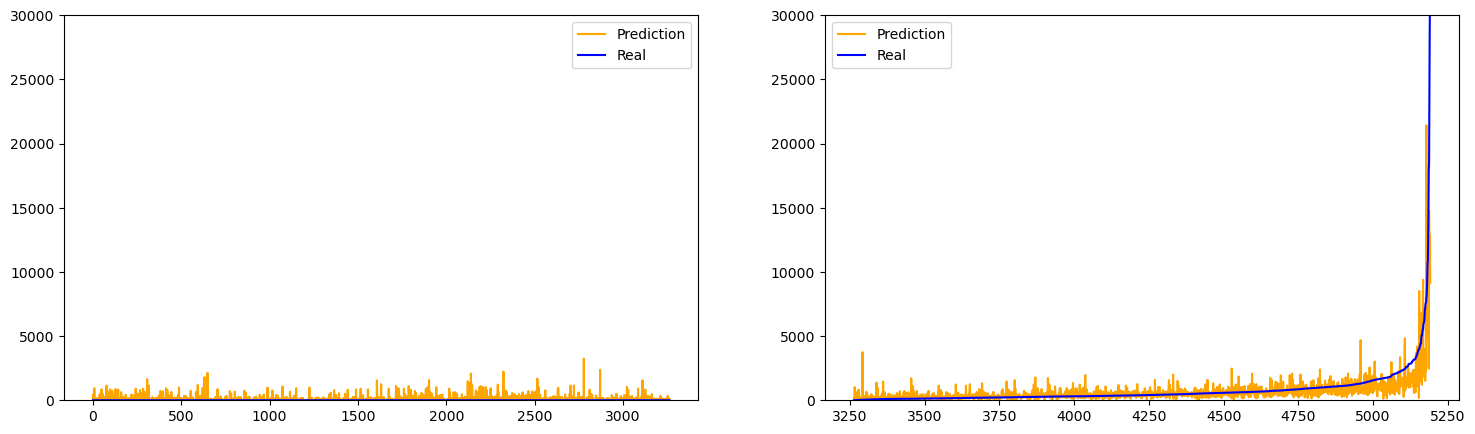

In [31]:
#put the predictions and targets in a dataframe
test_df = pd.DataFrame({'predictions': y_pred, 'targets': y_test})
#order the dataframe by the targets
test_df = test_df.sort_values(by='targets', ascending=True).reset_index(drop=True)
positive_df = test_df[test_df['targets'] > 0]
zero_df = test_df[test_df['targets'] == 0]

#plot the predictions and targets in the same plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (18, 5))
ax[1].plot(positive_df['predictions'], color = 'orange', label = 'Prediction')
ax[1].plot(positive_df['targets'],color  = 'blue', label  = 'Real')
ax[1].set_ylim(0, 5e5)
ax[1].legend()
ax[0].plot( zero_df['predictions'], color = 'orange', label = 'Prediction')
ax[0].plot( zero_df['targets'], color  = 'blue', label  = 'Real')
ax[0].legend()
ax[1].set_ylim(0, 30000)
ax[0].set_ylim(0, 30000)
fig.show()


(0.0, 5000.0)

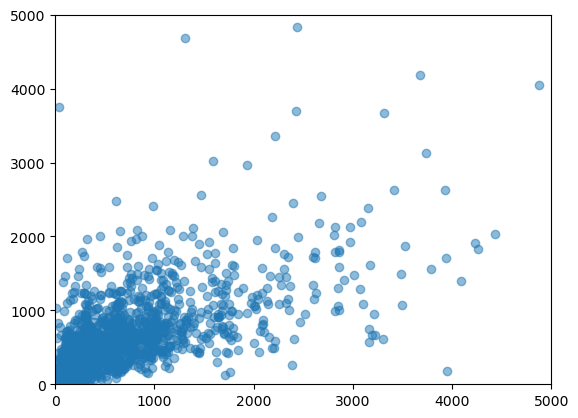

In [32]:
plt.scatter(positive_df['targets'], positive_df['predictions'], alpha=0.5)
plt.xlim(0, 5000)
plt.ylim(0, 5000)

In [36]:
import umap

# Reduce X_test to 2D using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_test_umap = umap_model.fit_transform(X_test)



/Users/ip/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_12531/3056341312.py:3: RuntimeWarning: divide by zero encountered in log
  scatter = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=np.log(y_test), alpha=1, cmap='magma', s=15)


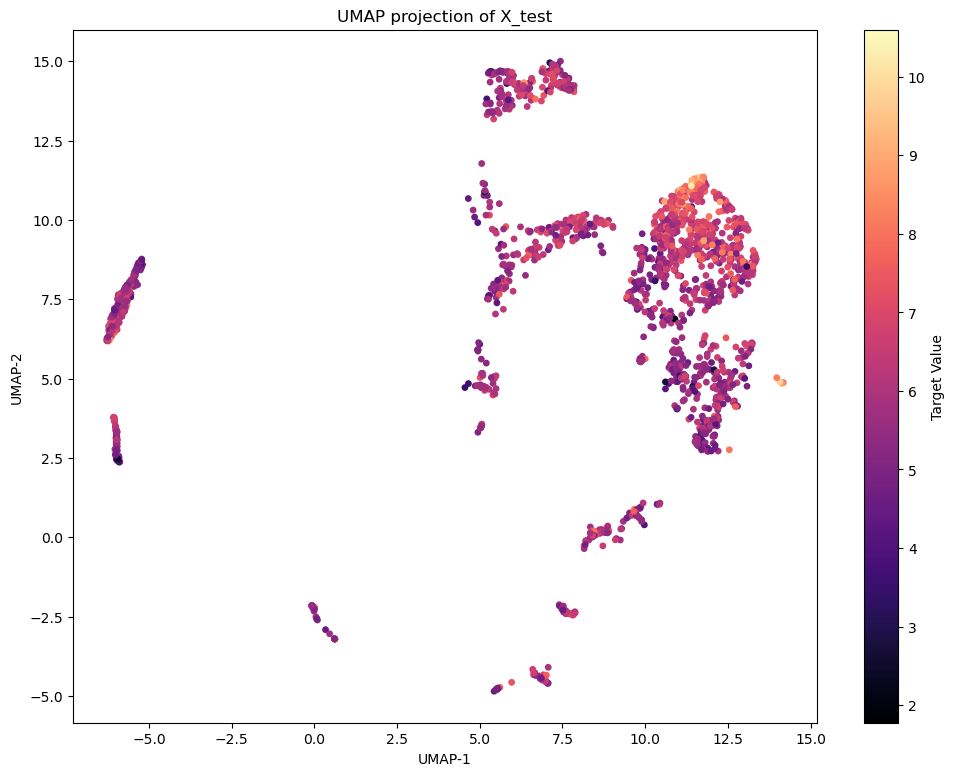

In [37]:
# Plot the results, colored by target value
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=np.log(y_test), alpha=1, cmap='magma', s=15)
plt.colorbar(scatter, label='Target Value')
plt.title('UMAP projection of X_test')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()